In [1]:
def show_state(env, step=0, name="", info=""):
    """Fn to visualize the agent playing the game in a notebook
    """
    plt.figure(10)
    plt.clf()
    plt.imshow(env.render(mode="rgb_array"))
    plt.title("{} | Step: {} {}".format(name, step, info))
    plt.axis('off')
    display.clear_output(wait=True)
    display.display(plt.gcf())

In [2]:
import torch
from scipy import optimize
import torch.nn.functional as F
import math
import numpy as np
from functools import reduce
from collections import OrderedDict

class PyTorchObjective(object):
    """PyTorch objective function, wrapped to be called by scipy.optimize."""
    def __init__(self, agent):
        self.f = agent.nn # some pytorch module, that produces a scalar loss
        # make an x0 from the parameters in this module
        parameters = OrderedDict(agent.nn.named_parameters())
        self.param_shapes = {n:parameters[n].size() for n in parameters}
        # ravel and concatenate all parameters to make x0
        self.x0 = np.concatenate([parameters[n].data.numpy().ravel() 
                                   for n in parameters])
        
        self.eval_fn = agent.evaluate
        self.c = 0

    def unpack_parameters(self, x):
        """optimize.minimize will supply 1D array, chop it up for each parameter."""
        i = 0
        named_parameters = OrderedDict()
        for n in self.param_shapes:
            param_len = reduce(lambda x,y: x*y, self.param_shapes[n])
            # slice out a section of this length
            param = x[i:i+param_len]
            # reshape according to this size, and cast to torch
            param = param.reshape(*self.param_shapes[n])
            named_parameters[n] = torch.from_numpy(param)
            # update index
            i += param_len
        return named_parameters

    def pack_grads(self):
        """pack all the gradients from the parameters in the module into a
        numpy array."""
        grads = []
        for p in self.f.parameters():
            grad = p.grad.data.numpy()
            grads.append(grad.ravel())
        return np.concatenate(grads)

    def is_new(self, x):
        # if this is the first thing we've seen
        if not hasattr(self, 'cached_x'):
            return True
        else:
            # compare x to cached_x to determine if we've been given a new input
            x, self.cached_x = np.array(x), np.array(self.cached_x)
            error = np.abs(x - self.cached_x)
            return error.max() > 1e-8

    def cache(self, x):
        # unpack x and load into module 
        state_dict = self.unpack_parameters(x)
        self.f.load_state_dict(state_dict)
        # store the raw array as well
        self.cached_x = x
        # zero the gradient
        self.f.zero_grad()
        # use it to calculate the objective
        score = self.eval_fn()
        self.cached_score = score

    def fun(self, x):
        self.c += 1
        if self.is_new(x):
            self.cache(x)
        if self.c % 10 == 0:
            print(f"achieved score of: {self.cached_score} on {self.c}")
        return self.cached_score

In [3]:
import gym_gvgai

In [4]:
from agent.NNagent import NNagent

In [5]:
from generator.env_gen_wrapper import GridGame

In [6]:
from scipy.optimize import Bounds

In [7]:
import matplotlib.pyplot as plt
from IPython import display


In [8]:
import matplotlib.pyplot as plt


In [9]:
_x = NNagent(GridGame(game='zelda', 
                     play_length=250,
                     path=gym_gvgai.dir + '/envs/games/zelda_v0/', 
                     lvl_name='zelda_lvl0.txt', 
                     mechanics=['1', '2', '3', '+', 'g', 'w'], # monsters, key, door, wall
                  )
         )

Connecting to host 127.0.0.1 at port 53847 ...
Client connected to server [OK]


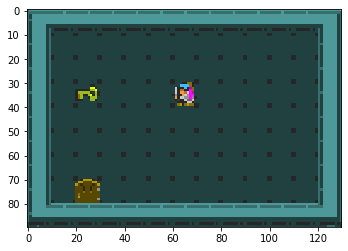

In [10]:
plt.imshow(_x.env.env.reset())

In [ ]:
_x.nn = torch.load("./25_gen_weights_5_5.pt")

In [11]:
_x.nn

Net(
  (conv1): Conv2d(14, 8, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(8, 32, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=96, out_features=48, bias=True)
  (fc2): Linear(in_features=48, out_features=24, bias=True)
  (fc3): Linear(in_features=24, out_features=6, bias=True)
)

In [12]:
grid = _x.env.reset()

In [13]:
grid.shape

(14, 9, 13)

In [14]:
z = PyTorchObjective(_x)

In [15]:
z.x0.shape


(9334,)

In [16]:
bounds = [(-5, 5)]*z.x0.shape[0]

In [17]:
from utils.diff_evo import differential_evolution

In [18]:
start = time.time()
ans = differential_evolution(z.fun, bounds, 
                             strategy='rand1bin',
                             popsize=99, 
                             maxiter=25,
                             polish=False, 
                             x0=z.x0)

100
achieved score of: -0.0 on 10
achieved score of: -0.0 on 20
achieved score of: -0.0 on 30
achieved score of: -0.0 on 40
achieved score of: -0.0 on 50
achieved score of: -0.0 on 60
achieved score of: -0.0 on 70
achieved score of: -0.0 on 80
achieved score of: -0.0 on 90
achieved score of: -0.0 on 100
achieved score of: -0.0 on 110
achieved score of: -0.0 on 120
achieved score of: -0.0 on 130
achieved score of: -0.0 on 140
achieved score of: -0.0 on 150
achieved score of: -0.0 on 160
achieved score of: -0.0 on 170
achieved score of: -0.0 on 180
achieved score of: -0.0 on 190
achieved score of: -0.0 on 200
achieved score of: -0.0 on 210
achieved score of: -0.0 on 220
achieved score of: -0.0 on 230
achieved score of: -0.0 on 240
achieved score of: -0.0 on 250
achieved score of: -0.0 on 260
achieved score of: -0.0 on 270
achieved score of: -0.0 on 280
achieved score of: -0.0 on 290
achieved score of: -1.0 on 300
achieved score of: -0.0 on 310
achieved score of: -0.0 on 320
achieved scor

achieved score of: -0.0 on 2600


In [19]:
end = time.time() - start
print(end)

13612.738213300705


In [20]:
ans

     fun: -2.0
 message: 'Maximum number of iterations has been exceeded.'
    nfev: 2600
     nit: 25
 success: False
       x: array([-4.69794577,  4.67742861,  3.73084908, ...,  1.8266111 ,
        1.73762558, -3.39886246])

In [21]:
z.x0 = ans.x

In [22]:
state_dict = z.unpack_parameters(ans.x)
z.f.load_state_dict(state_dict)

<All keys matched successfully>

In [23]:
z.f == _x.nn

True

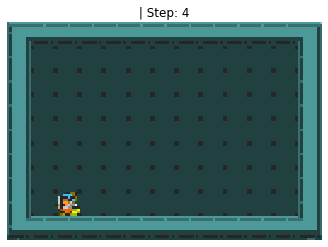

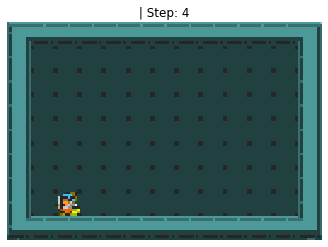

In [27]:
_x.fitness(fn=show_state)

In [25]:
_x.vis=None

In [26]:
torch.save(_x.nn, "./25_gen_weights_5_5.pt")

# Note. 

Moving the key from top right corner to mid left created a slightly simpler env.

----  

we were not able to learn the good policy if we kept the wieght range as [-2, 2]. 

Next I am retrying the same starting point but with range [-5, 5]. --> solved extremely simple env with this range and simpler env. 



----  
Then moving the key up one spot meant that the agent needs more training. So far it has failed to take the key and get to the goal after an additional 20 generations of training (but does get the key). I am giving it another 20 generations. 

After the agent learns the new environment (key moved up one spot), I am going to take those weights and put them back into the first env (key moved back down one spot).